# Introduction

This notebook contains all the analysis done on Washington Post data set about school shootings in the US (link: https://github.com/washingtonpost/data-school-shootings).
As the size of the data set is quite small, most of the preliminary analysis was conducted in Excel. Here the main motivation and basic analysis will be presented together with the source code for the final vizualizations used in the narrative piece ["Exploration into two decades of school shootings in the United States"](https://julzerinos.github.io/school-shootings-analysis/) hosted on Github Pages.

# Motivation

While looking for an interesting data set that would contain information from a limited region, we started to wonder what would be more interesting for us.
Data sets from the US are one of the most common to use, as they cover quite big areas as well as having a robust structure.
The US has been struggling with school shootings for the last couple of years, which seemed an interesting case study, as this phenomenon is observed in the vast majority only there.


The purpose of our analysis is to determine if there are any time patterns that could help prevent further tradegies.
Furthermore, we will investigate cultural response and news trends. We will also look into different counterstategies that should prevent further accidents.
Based on data analysis we want to determine how effective are they.


We want to draw attention to this problem, as it seems that it has partly dissappeared from social media, which does not mean that the number of accidents has dropped.
We want to show that the problem is not gone and that despite intuition, the threat comes from pupils, not adults.

## Dataset

Our dataset contain information about the shootings that happened in schools. It starts with the first big massive school shooting in Columbine High School and includes data up to 2023.
It contains data regarding date and time of schooting as well as some characteristics about the shooter as his age, gender, source of weapon etc.
We also used the dataset from RAND about the gun ownership in the US. We wanted to examine if there is any connection between the number of weapons per household and the number of shootings in the area.

# Basic stats

Here we present some basic analysis we performed on dataset in order to get acquainted with it.

Each entry in our dataset is a tragic event that should not have happen in a modern world, therefore it is really hard to generalize things and apply statistical models.
Nonetheless, we will try to look for some patterns as well as connections between this accidents and other environmental factors. 

### Imports

In order to be able to run the notebook you need to install all the needed libraries. To do so we prepared file with requirements that helps intall everything at once.
To do so run the command: 
``` 
pip install -r requirements.txt
```

In [1]:
import pandas as pd
import geopandas as gpd

import numpy as np
import datetime
import math
import calendar

import folium

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import geojson
%matplotlib inline

## Dataset preprocessing

Dataset needs to be downloaded beforehand as it is not part of the repository. It should be placed one folder outside of the repository. 
First let's load the data and have a quick pick at it.

In [2]:
df = pd.read_csv("../../data//school_shooting_data.csv")
# print some data
print(df.head(10))
# check what columns are available
print(df.columns)

   uid nces_school_id                       school_name  nces_district_id   
0    1   080480000707             Columbine High School          804800.0  \
1    2   220054000422       Scotlandville Middle School         2200540.0   
2    3   130441001591              Heritage High School         1304410.0   
3    4   421899003847          John Bartram High School         4218990.0   
4    5   250279000225            Dorchester High School         2502790.0   
5    6   350069000240              Deming Middle School         3500690.0   
6    7   401197000559         Fort Gibson Middle School         4011970.0   
7    8   120153001590             Ridgewood High School         1201530.0   
8    9   062460009581    Alicia Reyes Elementary School          624600.0   
9   10   170993000748  Duke Ellington Elementary School         1709930.0   

                          district_name        date school_year  year   
0                  Jefferson County R-1   4/20/1999   1998-1999  1999  \
1  Eas

As we see there are multiple columns for us the most interesting ones are related to date and time and shooter characteristics, we notice that there are different time format used.

Lets check how many empty data withing date and time columns we have.

In [5]:
print("Empty date dolumn: ",df['date'].isna().sum())
print("Empty time dolumn: ",df['time'].isna().sum())

Empty date dolumn:  0
Empty time dolumn:  20


As we see we have all of the dates but some time stamps are missing. We will not remove those lines, as they might be some valuable incidents there. Those 20 records will not be considered while analyzing hour pattern, but they will be used in analyzing date and weekday patterns.

**We also decided not to remove partial years (1999, 2023) as they provide valuable input to the analysis. Also one of the biggest massive shootings that started whole reasearch in this area, happened in 1999 (Columbine High School).**

Here we prepared function that maps all the different time formats used in the dataset to datetime object.

In [3]:
def convert_timestring_to_time(date_string):
    if date_string is np.nan:
        return date_string
    idx = date_string.find('M')
    if( idx ==-1):
        return datetime.datetime.strptime(date_string, '%H:%M')
    idx -=2
    if date_string[idx] == ' ':
        return datetime.datetime.strptime(date_string, '%I:%M %p')
    return datetime.datetime.strptime(date_string, '%I:%M%p')

As the date is always the same format, we can map time and date to datetime objects.
That will be helpful later when we will aggregate data. 

In [4]:
df['time'] = df['time'].apply(lambda x: convert_timestring_to_time(x))
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

As we will be also displaying data on maps, we need to remove all data that does not contain location point.

We have already verified it in Excel that there is only 1 record that does not have latitude and longitude.

In [5]:
df = df[df['long'].notna()]
df = df[df['lat'].notna()]
df.reset_index(drop=True, inplace=True)

As the dataset contains of only 367 entries we decided to also have a closer look at it in the excel sheet. We notices that there are multiple data missing from the shooters characteristics and relation to deceased as well as the gun origin and type. Even though, we decided not to remove those entries, as loosing those records would change the results of conducted analysis.


We prepare the path for the generated files and declare colors that will be used for charts:

In [6]:
# paths
html_path = '../docs/assets/htmls/'
include_path ='../docs/_includes/'
image_path = '../docs/assets/imgs/'
# colors
color_dark = '#000000'
color_light = '#FFFFFF'
color_dark_accent = '#14213D'
color_light_accent = '#E5E5E5'
color_highlight = '#FCA311'
color_dark_accent_2 = '#3d3d3d'

Add font for matplot lib

In [7]:
import requests
from tempfile import NamedTemporaryFile
font_url = 'https://github.com/google/fonts/blob/main/ofl/rubik/Rubik%5Bwght%5D.ttf' + '?raw=true'

response = requests.get(font_url)
with NamedTemporaryFile(delete=False, suffix='.ttf') as f:
    f.write(response.content)
    
    fm.fontManager.addfont(f.name)
    prop = fm.FontProperties(fname=f.name)
    print(f"Added new font to matplotlib with name {prop.get_name()} of {prop.get_family()}")

Added new font to matplotlib with name Rubik of ['sans-serif']


## Initial stats


In [11]:
print("Shape of the data set:", df.shape)
df.head()

Shape of the data set: (365, 50)


,uid,nces_school_id,school_name,nces_district_id,district_name,date,school_year,year,time,day_of_week,...,lat,long,staffing,low_grade,high_grade,lunch,county,state_fips,county_fips,ulocale
0,1,080480000707,Columbine High School,804800.0,Jefferson County R-1,1999-04-20,1998-1999,1999,1900-01-01 11:19:00,Tuesday,...,39.603910,-105.075000,89.6,9,12,41,Jefferson County,8,8059,21.0
1,2,220054000422,Scotlandville Middle School,2200540.0,East Baton Rouge Parish School Board,1999-04-22,1998-1999,1999,1900-01-01 12:30:00,Thursday,...,30.529958,-91.169966,39.0,6,8,495,East Baton Rouge Parish,22,22033,12.0
2,3,130441001591,Heritage High School,1304410.0,Rockdale County,1999-05-20,1998-1999,1999,1900-01-01 08:03:00,Thursday,...,33.626922,-84.047960,84.0,9,12,125,Rockdale County,13,13247,21.0
3,4,421899003847,John Bartram High School,4218990.0,Philadelphia City SD,1999-10-04,1999-2000,1999,1900-01-01 10:00:00,Monday,...,39.921509,-75.234108,41.0,9,12,2007,Philadelphia County,42,42101,11.0
4,5,250279000225,Dorchester High School,2502790.0,Boston,1999-11-03,1999-2000,1999,1900-01-01 07:40:00,Wednesday,...,42.285268,-71.075901,NaN,9,12,543,Suffolk County,25,25025,11.0


In [12]:
print("Latest and earliest shooting events")
print(df['date'].max(), df['date'].min())
print("Days covered:", (df['date'].max() - df['date'].min()).days)

Latest and earliest shooting events
2023-02-02 00:00:00 1999-04-20 00:00:00
Days covered: 8689


In [13]:
print("one school shooting per days:")
(df['date'].max() - df['date'].min()).days / len(df)

one school shooting per days:


23.805479452054794

In [14]:
print("Casualties")
print("sum", df['casualties'].sum())
print(df['casualties'].describe())
print()
print("Deaths")
print("sum", df['killed'].sum())
print(df['killed'].describe())
print()
print("injured")
print("sum", df['injured'].sum())
print(df['injured'].describe())

Casualties
sum 601
count    365.000000
mean       1.646575
std        3.945859
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max       34.000000
Name: casualties, dtype: float64

Deaths
sum 191
count    365.000000
mean       0.523288
std        2.214495
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       26.000000
Name: killed, dtype: float64

injured
sum 412
count    365.000000
mean       1.128767
std        2.268361
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max       21.000000
Name: injured, dtype: float64



Let's check how big shooting problem is in the US and let have a closer look at the age of the shooter.

Shootings per year:

In [15]:
casualties_per_year = df.groupby(['year']).agg(
     sum_casualties = ('casualties','sum'),
     sum=('year', 'count')
     ).reset_index()
fig = px.bar(casualties_per_year, x='year', y='sum_casualties')
fig.show()

We can see that there are some fluctuations within these 20 years, probably they are cause by the policies employed to prevent shootings.
We see that during COVID pandemic the amount of incidents dropeed, but surprisingly it significantly increased to almost 100 accidents in 2022. 

Age of the shooter:

In [16]:
# remove empty lines
age_of_the_shooter = df[df['age_shooter1'].notna()]
# convert age to int
age_of_the_shooter['age_shooter1'] = age_of_the_shooter['age_shooter1'].astype(int)
age_of_the_shooter = age_of_the_shooter.groupby(['age_shooter1']).agg(
     sum_age = ('age_shooter1','count')
     ).reset_index()
fig = px.bar(age_of_the_shooter, x='age_shooter1', y='sum_age')
fig.show()

C:\Users\j\AppData\Local\Temp\ipykernel_17700\169206493.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



As the diagrams show the age of the shooter is usually between 13 and 20 years old, let's check the median:

In [17]:
ages = df[df['age_shooter1'].notna()]
np.median(ages['age_shooter1'])

16.0

This investigation shows that indeed the shooters are usually students not adult people with probably mental issues. 
This insight will be a starting point for our investigation.

# Data analysis 

Diagrams from that part are saved directly to folders and will be later used for visualizations in webpage.

## Aggregate by time

We will have a look if there are any date time patterns within data.


### Yearly victims amount and accidents
Firstly we will look what is the trend for the last years.

In [18]:
shootings_per_year = df.groupby(['year']).agg(
     sum_killed = ('killed','sum'),
     sum_injured = ('injured','sum'),
     sum=('year', 'count')
     ).reset_index()

In [34]:
fig = go.Figure(
    data = [
        go.Bar(
            x=shootings_per_year['year'], 
            y=shootings_per_year['sum_injured'], 
            offsetgroup=0, name='People injured', 
            hovertemplate='Year: %{x} <br> Injured: %{y}', 
            hovertextsrc='',
            ),
        go.Bar(
            x=shootings_per_year['year'], 
            y=shootings_per_year['sum_killed'], 
            customdata=shootings_per_year['sum_killed'], 
            offsetgroup=0, name='People killed', 
            hovertemplate='Year: %{x} <br> Killed: %{customdata}',
            ),
        go.Line(
            x=shootings_per_year['year'], 
            y=shootings_per_year['sum'], 
            name='All incidents', 
            hovertemplate='Year: %{x} <br> Incidents count: %{y}',
            ),
    ]
)

fig.update_traces(
    marker=dict(
        line=dict(
            width=1,
            color=color_light_accent
        )
    )
)

fig.update_layout(
    width=630, 
    height=500,
    title="School shooting casualties vs occurences per year",
    title_x=.5,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1,
        showline=True,
        mirror=True,
        linecolor="#000000"
    ),
    yaxis=dict(
        showline=True,
        mirror=True,
        linecolor="#000000",
    ),
    xaxis_title="Year",
    yaxis_title="Count of casualties/occurences",
    font=dict(family='Rubik', size=12, color=color_dark),
    plot_bgcolor=color_light,
    modebar=dict(
        remove=[
             "autoScale2d", "autoscale", "editInChartStudio", "editinchartstudio", "hoverCompareCartesian", "hovercompare", "lasso", "lasso2d", "orbitRotation", "orbitrotation", "pan", "pan2d", "pan3d", "reset", "resetCameraDefault3d", "resetCameraLastSave3d", "resetGeo", "resetSankeyGroup", "resetScale2d", "resetViewMapbox", "resetViews", "resetcameradefault", "resetcameralastsave", "resetsankeygroup", "resetscale", "resetview", "resetviews", "select", "select2d", "sendDataToCloud", "senddatatocloud", "tableRotation", "tablerotation", "toImage", "toggleHover", "toggleSpikelines", "togglehover", "togglespikelines", "toimage", "zoom", "zoom2d", "zoom3d", "zoomIn2d", "zoomInGeo", "zoomInMapbox", "zoomOut2d", "zoomOutGeo", "zoomOutMapbox", "zoomin", "zoomout"
        ],
        orientation='h',
    ),
    colorway=[color_dark_accent_2, color_dark_accent, color_highlight],
    legend_traceorder="reversed", 
    barmode='stack'
) 
# saving
chart_div = plotly.offline.plot(fig, output_type='div')
with open(include_path + "shootings_details.html", 'w') as f:
    f.write(chart_div)

c:\Users\j\miniconda3\envs\social-data-viz\lib\site-packages\plotly\graph_objs\_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




We see that there are some fluctuations, and usually the number of killed people is quite low, except for the years with massive shootings (1999, 2012, 2018 and 2022). In 2018 and 2022 we observe a big rise in both killed and injured victims due to the incidents in Santa Fe high School and Marjory Stoneman Douglas High school (2018) and Robb Elementary School (2022). 

Between 1999 and 2017 the number of accidents per year was quite similar, while years 2018 and 2022 have an outstanding number of both killed and injured people. This indicate that the gun problem is far from gone.

### Hour
Diagram of time of all the shootings.

In [35]:
# hour
df['hour'] = df['time'].dt.hour
shootings_per_hour = df.loc[:, ['hour']]
shootings_per_hour = shootings_per_hour.groupby(
    ['hour']
    ).aggregate(
        count=('hour', 'count')
        ).reset_index()
fig = px.bar(shootings_per_hour, x="hour", y="count", height=350, width=630)

fig.update_traces(
    hovertemplate='Hour: %{x} <br>Incidents: %{y}',
    marker_line_color=color_dark_accent,
    marker_color=color_dark_accent_2
)
fig.update_layout(
    title="Aggregated school shootings per hour",
    title_x=.5,
    legend_title="Incidents",
    xaxis_range=[0, 23],
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1,
        showline=True,
        mirror=True,
        linecolor="#000000"
    ),
    yaxis=dict(
        showline=True,
        mirror=True,
        linecolor="#000000"
    ),
    xaxis_title="Hour",
    yaxis_title="Count",
    font=dict(family='Rubik', size=12, color=color_dark),
    plot_bgcolor=color_light,
    modebar=dict(
        remove=[
             "autoScale2d", "autoscale", "editInChartStudio", "editinchartstudio", "hoverCompareCartesian", "hovercompare", "lasso", "lasso2d", "orbitRotation", "orbitrotation", "pan", "pan2d", "pan3d", "reset", "resetCameraDefault3d", "resetCameraLastSave3d", "resetGeo", "resetSankeyGroup", "resetScale2d", "resetViewMapbox", "resetViews", "resetcameradefault", "resetcameralastsave", "resetsankeygroup", "resetscale", "resetview", "resetviews", "select", "select2d", "sendDataToCloud", "senddatatocloud", "tableRotation", "tablerotation", "toImage", "toggleHover", "toggleSpikelines", "togglehover", "togglespikelines", "toimage", "zoom", "zoom2d", "zoom3d", "zoomIn2d", "zoomInGeo", "zoomInMapbox", "zoomOut2d", "zoomOutGeo", "zoomOutMapbox", "zoomin", "zoomout"
        ],
        orientation='h',
    ),
)

chart_div = plotly.offline.plot(fig, output_type='div')
with open(include_path + "shootings_hour.html", 'w') as f:
    f.write(chart_div)

As expected most of the incident happen during school hours, there is only one outstanding observation that happen on a parking lot.

There is no particular hour that would be more dangerous for kids, although we can observe a small drop of incidents during lunch hours (10-12).

### Month
Diagram of all the monts and accidents that happened.

In [36]:
# month
df['month'] = df['date'].dt.month
shootings_per_month = df.loc[:, ['month']]
shootings_per_month = shootings_per_month.groupby(
    ['month']
    ).aggregate(
        count=('month', 'count')
        ).reset_index()
fig = px.bar(shootings_per_month, x="month", y="count", height=350, width=630)

fig.update_traces(
    hovertemplate='Month: %{x} <br> Incidents: %{y}',
    marker_line_color=color_dark_accent,
    marker_color=color_dark_accent_2
)
fig.update_layout(
    title="Aggregated school shootings per weekday",
    title_x=.5,
    legend_title="Incidents",
    xaxis=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
                showline=True,
        mirror=True,
        linecolor="#000000"
    ),
    yaxis=dict(
        showline=True,
        mirror=True,
        linecolor="#000000"
    ),
    xaxis_title="Month",
    yaxis_title="Count",
    font=dict(family='Rubik', size=12, color=color_dark),
    plot_bgcolor=color_light,
    modebar=dict(
        remove=[
             "autoScale2d", "autoscale", "editInChartStudio", "editinchartstudio", "hoverCompareCartesian", "hovercompare", "lasso", "lasso2d", "orbitRotation", "orbitrotation", "pan", "pan2d", "pan3d", "reset", "resetCameraDefault3d", "resetCameraLastSave3d", "resetGeo", "resetSankeyGroup", "resetScale2d", "resetViewMapbox", "resetViews", "resetcameradefault", "resetcameralastsave", "resetsankeygroup", "resetscale", "resetview", "resetviews", "select", "select2d", "sendDataToCloud", "senddatatocloud", "tableRotation", "tablerotation", "toImage", "toggleHover", "toggleSpikelines", "togglehover", "togglespikelines", "toimage", "zoom", "zoom2d", "zoom3d", "zoomIn2d", "zoomInGeo", "zoomInMapbox", "zoomOut2d", "zoomOutGeo", "zoomOutMapbox", "zoomin", "zoomout"
        ],
        orientation='h',
    ),
)


chart_div = plotly.offline.plot(fig, output_type='div')
with open(include_path + "shootings_month.html", 'w') as f:
    f.write(chart_div)

As expected, the lowest number of incidents is during the holiday moths (June, July, August).
Month with the highest shooting incidents number is January, which may be surprising as in December the number of incidents is 2 times smaller. 

### Weekday

Diagram presenting all the incidents per weekday

In [37]:
# weekday
cat = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
shootings_per_weekday = df.loc[:, ['day_of_week']]
shootings_per_weekday = shootings_per_weekday.groupby(
    ['day_of_week']
    ).aggregate(
        count=('day_of_week', 'count')
        ).reindex(cat)
shootings_per_weekday['weekday'] = shootings_per_weekday.index

fig = px.bar(shootings_per_weekday, x="weekday",
             y="count", height=350, width=630)

fig.update_traces(
    hovertemplate='Weekday: %{x} <br> Incidents: %{y}',
    marker_line_color=color_dark_accent,
    marker_color=color_dark_accent_2
)
fig.update_layout(
    title="Aggregated school shootings per month",
    title_x=.5,
    xaxis_title="Weekday",
    yaxis_title="Count",
    xaxis=dict(
        showline=True,
        mirror=True,
        linecolor="#000000"
    ),
    yaxis=dict(
        showline=True,
        mirror=True,
        linecolor="#000000"
    ),
    font=dict(family='Rubik', size=12, color=color_dark),
    plot_bgcolor=color_light,
    modebar=dict(
        remove=[
             "autoScale2d", "autoscale", "editInChartStudio", "editinchartstudio", "hoverCompareCartesian", "hovercompare", "lasso", "lasso2d", "orbitRotation", "orbitrotation", "pan", "pan2d", "pan3d", "reset", "resetCameraDefault3d", "resetCameraLastSave3d", "resetGeo", "resetSankeyGroup", "resetScale2d", "resetViewMapbox", "resetViews", "resetcameradefault", "resetcameralastsave", "resetsankeygroup", "resetscale", "resetview", "resetviews", "select", "select2d", "sendDataToCloud", "senddatatocloud", "tableRotation", "tablerotation", "toImage", "toggleHover", "toggleSpikelines", "togglehover", "togglespikelines", "toimage", "zoom", "zoom2d", "zoom3d", "zoomIn2d", "zoomInGeo", "zoomInMapbox", "zoomOut2d", "zoomOutGeo", "zoomOutMapbox", "zoomin", "zoomout"
        ],
        orientation='h',
    ),
)

chart_div = plotly.offline.plot(fig, output_type='div')
with open(include_path + "shootings_weekday.html", 'w') as f:
    f.write(chart_div)

Again, there is no surprise there are no incidents during weekend. 

We can notice that the highest number of shootings happen in Tuesday.

### Year

In [38]:
df['Year'] = df['date'].dt.year
school_shooting_by_year = df.loc[:, ['Year']].value_counts().reset_index()

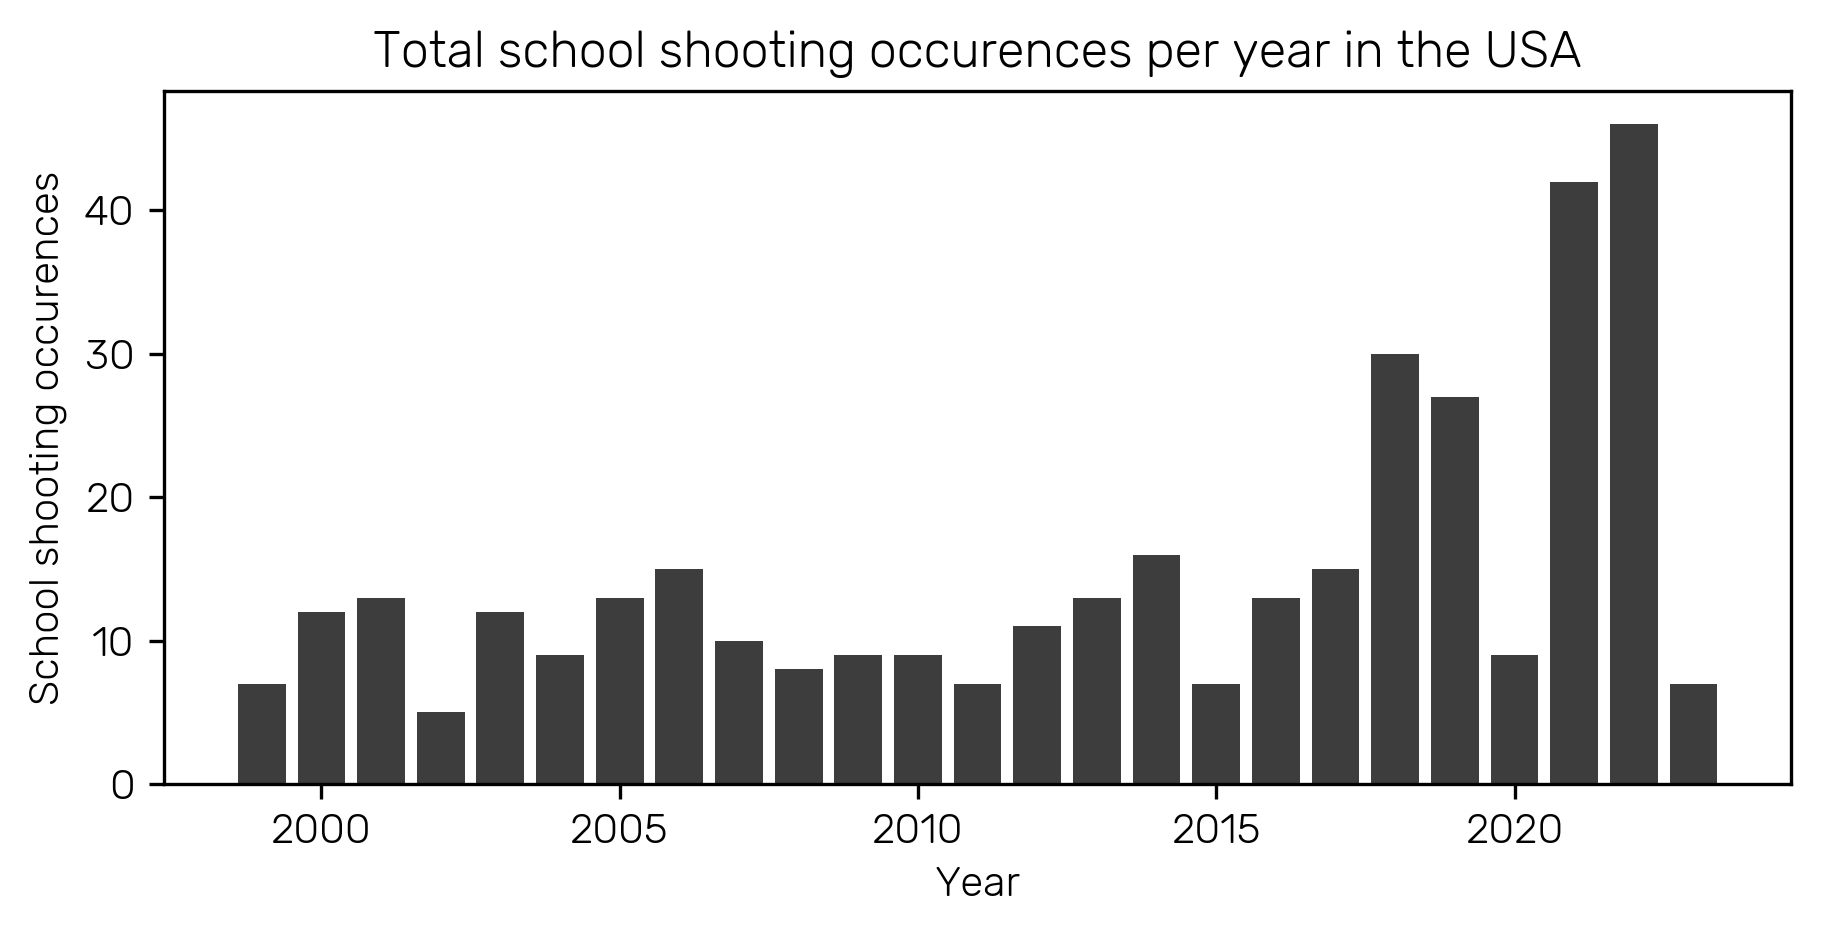

In [39]:
# matplotlib configuration
mpl_runtime_config_context = {
    'axes.prop_cycle': f"cycler('color', ['{color_highlight}', '{color_dark_accent}',])",
    'font.family': 'Rubik',
    }

with plt.rc_context(mpl_runtime_config_context):
    fig = plt.figure(figsize=(7, 3), dpi=300)
    plt.title("Total school shooting occurences per year in the USA")
    plt.xlabel("Year")
    plt.ylabel("School shooting occurences")
    plt.bar(school_shooting_by_year['Year'], school_shooting_by_year['count'], color='#3d3d3d')
fig.savefig('../docs/assets/imgs/total_shootings.png', bbox_inches="tight")

### Accidents distribution per state

In [40]:
school_shootings_by_state = df.loc[:, ['state', 'injured', 'killed']].value_counts().reset_index().groupby(
    by=['state']
    ).sum().reset_index()
# load geojson with state data
states_data = gpd.read_file("../../data/gz_2010_us_040_00_500k.json")

states_with_data = states_data.merge(school_shootings_by_state, left_on="NAME", right_on="state", how="outer") 
states_with_data.fillna(0, inplace=True)

# generate map

map = folium.Map(location=[ 40, -96, ], zoom_start= 3.5, tiles=None)
base_map = folium.FeatureGroup(name='BaseMap', overlay=True, control=False)
folium.TileLayer(tiles='openstreetmap').add_to(base_map)
base_map.add_to(map)

style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0, 
                            'weight': 2 if x['properties']['STATE'] in ['06', '48', '12', '09', '37', '08'] else .1,
                            }
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
overlay_1 = folium.features.GeoJson(
    states_with_data,
    style_function=style_function, 
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME','count', 'injured', 'killed'],  # use fields from the json file
        aliases=['State: ','Total occurences: ', 'Total injured victims: ', 'Total killed victims: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    ),
)
overlay_2 = folium.features.GeoJson(
    states_with_data,
    style_function=style_function, 
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['NAME','count', 'injured', 'killed'],  # use fields from the json file
        aliases=['State: ','Total occurences: ', 'Total amount of injured victims: ', 'Total amount of killed victims: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    ),
)

layer1 = folium.FeatureGroup(name="School shooting total occurences", control=True, overlay=False)
ss_occurences = folium.Choropleth(
            geo_data='../../data/gz_2010_us_040_00_500k.json',
            name='School shooting occurence intensity',
            data=states_with_data,
            columns=['GEO_ID', 'count'],
            key_on='feature.properties.GEO_ID',
            fill_color='YlOrRd',
            nan_fill_color="White",
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Count of total school shooting incidents',
            line_color='black',
        )
ss_occurences.geojson.add_to(layer1) 
layer1.add_child(overlay_1)

layer2 = folium.FeatureGroup(name='School shooting total deaths', control=True, overlay=False)
ss_deaths = folium.Choropleth(
            geo_data='../../data/gz_2010_us_040_00_500k.json',
            name='School shooting deaths',
            data=states_with_data,
            columns=['GEO_ID', 'killed'],
            key_on='feature.properties.GEO_ID',
            fill_color='YlOrRd',
            nan_fill_color="White",
            fill_opacity=0.7,
            line_opacity=0.2,
            legend_name='Count of total school shooting deaths',
            line_color='black',
        )
ss_deaths.geojson.add_to(layer2) 
layer2.add_child(overlay_2)

map.add_child(layer1)
map.add_child(layer2)

# map.keep_in_front(NIL)

folium.LayerControl(collapsed=False).add_to(map)

map.save(html_path + "choropleth.html")


## Shooter characteristic

Diagram with shooter age and enthicity with distinguishing between women and men.

In [41]:
races= {'a': 'Asian', 'ai':'American Indian','b':'Black','h':'Hispanic','w':'White'}
def assign_race(race):
    if race is np.nan:
        return "Not known"
    if race in races:
        return races[race]
    return "Not known"

In [42]:
df['gender_shooter1'].isna().sum()
# assign race from dictionary
df['race_ethnicity_shooter'] = df['race_ethnicity_shooter1'].apply(lambda x: assign_race(x))
# reove cells where age of the shooter was not known
df = df[df['age_shooter1'].notna()]
# convert age to int
df['age_shooter1'] = df['age_shooter1'].astype(int)
# separate data for men and women
women = df[df['gender_shooter1'] == 'f']
men = df[df['gender_shooter1'] == 'm']
# aggregate women
women_ethnicity = women.loc[:,['age_shooter1','race_ethnicity_shooter']].value_counts(dropna=False).unstack() 
women_ethnicity = women_ethnicity.fillna(0)
women_ethnicity = women_ethnicity.reset_index()
#aggregate men
men_ethnicity = men.loc[:,['age_shooter1','race_ethnicity_shooter']].value_counts(dropna=False).unstack() 
men_ethnicity = men_ethnicity.fillna(0)
men_ethnicity = men_ethnicity.reset_index()

In [43]:
marker_color = {
    "Black":"#fd7f6f",
    "Not known":"#7eb0d5",
    "White": "#b2e061",
    "Hispanic":"#bd7ebe",
    "American Indian":"#ffb55a",
    "Asian": "#ffee65",
}

In [45]:
fig = make_subplots(rows=1, cols=2, column_widths=[0.3, 0.7], specs=[[{"type": "bar"}, {"type": "bar"}]], shared_xaxes=False,
                    shared_yaxes=True, horizontal_spacing=0)

base = np.zeros(shape=women_ethnicity.shape[0])
base = pd.Series(base)
for col in women_ethnicity.columns[1:]:
    fig.append_trace(go.Bar(name="Ethincity "+col,
                            x=women_ethnicity[col],
                            y=women_ethnicity['age_shooter1'],
                            hovertemplate='Ethinicity: ' + col + '<br>Count: ' + women_ethnicity[col].map(
                                '{:,.0f}'.format) + '<br>Age: ' + women_ethnicity['age_shooter1'].map('{:,.0f}'.format),
                            offsetgroup=0,
                            orientation='h',
                            width=0.7,
                            marker_color=marker_color[col],
                            showlegend=False,
                            base=base),
                     1, 1)  # 1,1 represents row 1 column 1 in the plot grid
    base = base.add(women_ethnicity[col])


base = np.zeros(shape=men_ethnicity.shape[0])
base = pd.Series(base)
for col in men_ethnicity.columns[1:]:
    fig.append_trace(go.Bar(name="Ethincity "+col,
                            x=men_ethnicity[col],
                            y=men_ethnicity['age_shooter1'],
                            hovertemplate='Ethinicity: ' + col + '<br>Count: ' + men_ethnicity[col].map(
                                '{:,.0f}'.format) + '<br>Age: ' + men_ethnicity['age_shooter1'].map('{:,.0f}'.format),
                            offsetgroup=1,
                            orientation='h',
                            width=0.7,
                            marker_color=marker_color[col],
                            showlegend=False,
                            base=base),
                     1, 2)  # 1,1 represents row 1 column 1 in the plot grid
    base = base.add(men_ethnicity[col])

fig.update_xaxes(showticklabels=False, title_text="Female",
                 row=1, col=1, range=[20, 0], fixedrange=True)
fig.update_xaxes(showticklabels=False, title_text="Male",
                 row=1, col=2, fixedrange=True)

fig.update_layout(
    title_text="Age of the shooter with ethnicity distinguished",
    width=800,
    height=700,
    xaxis1={'side': 'top'},
    xaxis2={'side': 'top'},
    margin=dict(b=50, l=50, r=50, t=150),
    barmode='relative',
    modebar=dict(
        remove=[
            "autoScale2d", "autoscale", "editInChartStudio", "editinchartstudio", "hoverCompareCartesian", "hovercompare", "lasso", "lasso2d", "orbitRotation", "orbitrotation", "pan", "pan2d", "pan3d", "reset", "resetCameraDefault3d", "resetCameraLastSave3d", "resetGeo", "resetSankeyGroup", "resetScale2d", "resetViewMapbox", "resetViews", "resetcameradefault", "resetcameralastsave", "resetsankeygroup", "resetscale", "resetview", "resetviews", "select", "select2d", "sendDataToCloud", "senddatatocloud", "tableRotation", "tablerotation", "toImage", "toggleHover", "toggleSpikelines", "togglehover", "togglespikelines", "toimage", "zoom", "zoom2d", "zoom3d", "zoomIn2d", "zoomInGeo", "zoomInMapbox", "zoomOut2d", "zoomOutGeo", "zoomOutMapbox", "zoomin", "zoomout"
        ],
        orientation='h',
    ),
)

plotly.offline.plot(fig, filename=html_path +
                    "shooter_age_gender_distribution.html")


'../docs/assets/htmls/shooter_age_gender_distribution.html'

Overall, most of the shooters were young male in their teens years. As we mentioned before there is a lot of unknown when it come to the shooters data, therefore almost 1/3 of the shooters do not have specified ethnicity.
Another big group is white and black males.

Female shooters also mostly do not have specified ethinicty group.

## Plot student's ethnicity distribution in schools

A pie chart showing the ethnic breakdown of students in the attacked schools.

In [46]:
def plot_student_race_distribution(races, column_names, title, file_path):
    races = races.dropna(axis=1)
    races = races.loc[:, (races != 0).any(axis=0)]
    names =[]
    for c in races.columns:
        names.append(column_names[c])
    fig = px.pie(values=races.values[0], names=names, title=title, height=290, width=320)
    fig.update_layout(uniformtext_minsize=6, uniformtext_mode='hide', legend=dict(
        font=dict(size=10), 
        yanchor="top",
        y=-0.01,
        xanchor="left",
        x=0.01
        ),
        margin=dict(l=20, r=20, t=20, b=20),
        font_size=8, title_font_size=10)
    fig.update_traces(hovertemplate='Ethnicity: %{label} <br>  Count: %{value}', textposition='inside')
    fig.update_traces(textfont_size=8)
    plotly.offline.plot(fig, filename=file_path, config=dict(displayModeBar=False))

In [47]:
df.reset_index(drop=True, inplace=True)

In [ ]:
column_names = {
   'white':'White', 
   'black':'Black', 
   'hispanic':'Hispanic', 
   'asian':'Asian',
   'american_indian_alaska_native':'American/Indian/Alaska native', 
   'hawaiian_native_pacific_islander':'Hawaiian native/Pacific islander'
   }
   
df['ethnicity_diagram_path'] = np.nan
for i in range(0, df.shape[0]):
    races = df.loc[[i], ['white', 'black', 'hispanic', 'asian',
       'american_indian_alaska_native', 'hawaiian_native_pacific_islander']]
    races = races._convert(numeric=True)
    schoolname = df.iloc[i]['school_name']
    filepath = './ethinicity_diagrams/' + schoolname.replace('/', '_') +'_ethinicity.html'
    filepathtosave= html_path + 'ethinicity_diagrams/' + schoolname.replace('/', '_') +'_ethinicity.html'
    diagram_title = f"Population of {schoolname} <br>({df.iloc[i]['school_type']} school)"
    plot_student_race_distribution(races, column_names, diagram_title, filepathtosave)
    df.at[i,'ethnicity_diagram_path']= filepath

In [ ]:
# Quick workaround for environment mismatch bug in pandas
if df['ethnicity_diagram_path'].hasnans:
    df['ethnicity_diagram_path'] = 'ethinicity_diagrams/' + df['school_name'].str.replace('/', '_') + '_ethinicity.html'

We plot ethnic distribution for each school to later in the detailed map with accidents, be able to examine if this breakdown has any impact on choosing this school as a target.
But quickly looking at the diagrams, we can notice that there is whole cross-section of data - there are school with only white people, mix with different majorities (black or white).
Usually other ethinicities, like Hispanic, Hawaiian native etc., make up a minority of the school community.

## Map with student's ethnicity in school

Detailed map with marked location of all of the incidents.
For each school location there is a popup with information about the incidents and victioms as well as diagram showing ethnicity breakdown.

In [49]:
def generate_color(killed, injured):
    if killed ==0 and injured==0:
        return 'blue'
    if killed ==0 :
        return 'gray'
    return 'crimson'

def calculate_circle_radius(max_affected, current_affected):
    return math.log(current_affected/ max_affected * 100 + 1.) * 2 + 4

In [98]:
colors = {'blue': 'Incident without causalities', 'gray': 'Incident with injured', 'crimson': 'Incident with killed'}
max_killed_and_injured = max(df['killed']) + max(df['injured'])
# Make an empty map
m = folium.Map(location=[40,-100], tiles="OpenStreetMap", zoom_start=2.5, height=600, width=640)
feature_groups = {}
lgd_txt = '<span style="color: {col};">{txt}</span>'
for c, t in colors.items():
   fg = folium.FeatureGroup(name=lgd_txt.format(col = c, txt=t))
   feature_groups[c] = fg

for i in range(0,df.shape[0]):
   killed_and_injured = df.iloc[i]['killed'] + df.iloc[i]['injured']
   # calculate radius
   radius = calculate_circle_radius(max_killed_and_injured, killed_and_injured)
   # prepare html text to embeed in map
   html=f"<div style='width:500px; height:300px; display:flex; font-size: 15px;' > \
       <div style='flex:45%; text-align: left;'> \
         <h3>Shooting details</h3>\
         <br\> \
         <span >\
            Date: {df.iloc[i]['date'].strftime('%d %B, %Y')}  <br \> \
            Time: {'' if pd.isnull(df.iloc[i]['time']) else df.iloc[i]['time'].strftime('%H:%M')}<br \> \
            Students enrolled at time of shooting: {df.iloc[i]['enrollment']} <br \> \
         <\span> \
         <br\> \
         <span> \
            Killed/casualties: {df.iloc[i]['killed']}/{df.iloc[i]['casualties']} <br \> \
            Injured/casualties: {df.iloc[i]['injured']}/{df.iloc[i]['casualties']} <br \>\
            Type of shooting: {df.iloc[i]['shooting_type']} <br \> \
               Age of shooter: {'Not known' if pd.isnull(df.iloc[i]['age_shooter1']) else df.iloc[i]['age_shooter1']} \
            <\span> \
         </div> \
         <div style='flex: 55%'> \
            <iframe scrolling='no' src='{df['ethnicity_diagram_path'][i]}' width='100%' height='100%'  frameborder='0'>    \
         </div> \
    </div> \
    "
   diagram = folium.Popup(folium.Html(html, script=True), min_width=500, min_height=300, max_width=500, max_height=300)
   color = generate_color(df.iloc[i]['killed'], df.iloc[i]['injured'])
   marker = folium.CircleMarker(
      location=[df.iloc[i]['lat'], df.iloc[i]['long']],
      radius=radius,
      popup=diagram,
      color=color,
      fill=True,
      fill_color=color
   )
   feature_groups[color].add_child(marker)
for _,fg in feature_groups.items():
   m.add_child(fg)
# Save the map
folium.map.LayerControl('topleft', collapsed=True).add_to(m)
# m
m.save(html_path+'shootings_details.html')


The purpose of this map was to let the user explore the data on his own.

The size of the marker indicated how many victims were injured and killed during that incident. Also the color of the marker depends wheather there were any fatalities, injuries or was it a victimless incident.

We can notice that most of the incident took place in the east coast. Interestingly enough, we can see that Denver, city of the big Columbine massacre was also the city of 5 other attacks, which 2 of them had fatalities.

## Gun ownership map

Map visualizing the average gun ownership in households in the US.
It also contains n the number of casuaities in each state.

In [8]:
file_name = '../../data/TL-354-State-Level Estimates of Household Firearm Ownership.xlsx'
sheet_to_df_map = pd.read_excel(file_name, sheet_name="State-Level Data & Factor Score")
gun_ownership = sheet_to_df_map.groupby(['STATE']).aggregate(
    average_ownership = ('HFR', 'mean')
).reset_index()
# convert rate to %
gun_ownership['average_ownership'] = gun_ownership['average_ownership'] * 100
# get shootings by state
school_shootings_by_state = df.groupby('state').aggregate( killed = ('killed', 'sum'), injured= ('injured', 'sum'), causalities = ('casualties', 'sum')).reset_index()

In [9]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

# generate abbreviations for states
school_shootings_by_state['state_abb'] = school_shootings_by_state['state'].apply(lambda x: us_state_to_abbrev[x])
gun_ownership['state_abb'] = gun_ownership['STATE'].apply(lambda x: us_state_to_abbrev[x])
result = pd.merge(school_shootings_by_state, gun_ownership, on='state_abb', how='outer')
result['causalities']  = result['causalities'].fillna(0)
result['killed']  = result['killed'].fillna(0)
result['injured']  = result['injured'].fillna(0)
result['average_ownership']  = result['average_ownership'].fillna(0)
result['text'] = result.apply(lambda row: f"{abbrev_to_us_state[row['state_abb']]} <br>Average % of households that own a gun: {round(row['average_ownership'],2)} % <br>Killed: {row['killed']}<br>Injured: {row['injured']}", axis=1)

In [11]:
layout = dict(
    font=dict(size=12, family='Rubik'),
    geo=dict(
        scope="usa",
        projection=dict(
            type="albers usa"
        )
    ),
    legend=dict(
        font=dict(
            color='black'
        )
    ),
    width=630,
    height=300,
    margin=dict(
        pad=0,
        b=0,
        t=0,
        l=0,
        r=0
    ),
    modebar=dict(
        remove=[
            "autoScale2d", "autoscale", "editInChartStudio", "editinchartstudio", "hoverCompareCartesian", "hovercompare", "lasso", "lasso2d", "orbitRotation", "orbitrotation", "pan", "pan2d", "pan3d", "reset", "resetCameraDefault3d", "resetCameraLastSave3d", "resetGeo", "resetSankeyGroup", "resetScale2d", "resetViewMapbox", "resetViews", "resetcameradefault", "resetcameralastsave", "resetsankeygroup", "resetscale", "resetview", "resetviews", "select", "select2d", "sendDataToCloud", "senddatatocloud", "tableRotation", "tablerotation", "toImage", "toggleHover", "toggleSpikelines", "togglehover", "togglespikelines", "toimage", "zoom", "zoom2d", "zoom3d", "zoomIn2d", "zoomInGeo", "zoomInMapbox", "zoomOut2d", "zoomOutGeo", "zoomOutMapbox", "zoomin", "zoomout"
        ],
        orientation='h',
    ),
)
data = []

data.append(go.Choropleth(locations=result['state_abb'], z=result['average_ownership'], locationmode="USA-states",
            colorscale="ylorrd", text=result["text"], hoverinfo='text', showscale=True, showlegend=False, name='Gun ownership'))
data.append(go.Scattergeo(locations=result['state_abb'], text=result['causalities'], locationmode="USA-states",
            mode="text", hoverinfo='skip', name='Amount of casualties', showlegend=False, textfont=dict(color='white')))

fig = go.Figure(data=data, layout=layout)
fig.update_layout(showlegend=True)

chart_div = plotly.offline.plot(fig, output_type='div')
with open(include_path + "us_gun_ownership.html", 'w') as f:
    f.write(chart_div)

Despite our initial intuition average gun ownership in household does not have any correlation with amount of shootings in school.

We would expect that the higher number of households with gun, the bigger number of incident in that state. But states with the highest gun ownership ratio - like Montana or Wyoming have one of the lowest number of victims. In those states most of the terrain is desserts, so there are not many households in the area and the majority of them do have at least one weapon, probably due to a cultural heritage.
Moreover states with high gun ownership rate have quite low number of victims.

There is no clear colleration between provided data, but we do believe that the ease of access to weapons has an impact on the number of accidents. In order to prove it we would need more detailed datasets. We did try to look for some better ones, but there is no record keep about the amount of guns in each state. 

# Genre

The major genre for our work is the "magazine style". We opted for this 'narrative' genre, as it allowed us to provide a linear and streamlined train of thought to the reader. The goal is the walk the user throught the data set while providing internal insight as well as backing that up with external sources.

We use inspiration from other styles as minor themes. We've included annotated, interactive maps to enable data exploration for the reader and provided sources on related video media for the reader to explore the topic further.

Noteworthy tools we have employed are

* Consistent visual platform, by ensuring our visuals are maintained in the same style.
* Feature distinction for key data points in graphs, charts and maps.
* Zooming is enabled in most analytical elements, especially maps.
* Accessibility preference, by optimizing the web site with both dark mode and light mode options.
* Linear strucutre to guide the reader's journey through the data set.
* Interactivity and providing more details on hover or click, to allow the reader to dive deeper into the data.
* Clear sections including an introduction and summary to provide an opening and closure to the story.

Each record is a separate story that should be told. There are a lot of different aspects that should be introduced using text and not only diagrams or maps.

We organised the page so that reader is guided from one section to the next. There is a strong connection between subsequent sections, and the successive sections form a logical whole. Our maps have different layers that can be filtered out (filtering) we also used different marker sized to highlighten more important points. Most of diagrams contains hover with more detailed text that provides related information. 

Beginning of the article has an introduction stating what is the purpose of the project. Moreover, each section has a headline and there is also a summary part. There are some external links to the sources and dataset. Diagrams have titles and axis description.

# Visualizations

Since the data set is of the type geospatial across time, our graphs revolve around two categories: time aggregates and maps.

The time aggregates allow us to show patterns and changing trends across time. This was especially true for the annual change as it helps understand the big picture - the concerning increase in shootings nation-wide.

Maps allow us to understand hot spots of the issue and also provides a glimpse into the societal difference across states. It is much more impactful to understand where infamous mass shootings like Columbine actually occurred and provides the user with an oppurtunity to bind reality with numbers in a table.

Another type of visualization used is a time series chart. This was used for the Google trends data to provide a more granular glimpse into the changing environment of cultural tolerance for school shootings.

### Google trends chart

In [ ]:
school_shooting_keyword_trend = pd.read_csv('../../data/google_trends_school_shooting_keyword.csv')
school_shooting_keyword_trend.Month = pd.to_datetime(school_shooting_keyword_trend.Month)
school_shooting_keyword_trend.sort_values(by=['Month'], ascending=True, inplace=True)

peaks = school_shooting_keyword_trend.nlargest(3, columns=['school shooting: (Worldwide)'])

In [ ]:
with plt.rc_context(mpl_runtime_config_context):
    fig = plt.figure(figsize=(6, 13), dpi=300)
    plt.title('Google trends for keyword "school shooting"', pad=10)

    plt.gca().invert_yaxis()
    plt.ylabel('Time')

    # plt.xlabel('Interest relative to peak')
    plt.xlim((-5, 105))
    ax = plt.twiny()
    ax.set_xlabel("Interest relative to peak")

    plt.vlines(100, ymin=school_shooting_keyword_trend.Month.min(), ymax=school_shooting_keyword_trend.Month.max(), colors=[color_highlight], linestyles=['dotted'])
    plt.hlines(peaks.Month, xmin=-10, xmax=110, colors=[color_highlight], linestyles=['dotted'])
    plt.plot(school_shooting_keyword_trend['school shooting: (Worldwide)'], school_shooting_keyword_trend.Month)

    plt.text(x=47, y=pd.Timestamp.fromtimestamp(peaks.iloc[0, 0].timestamp() - 10000000), s="Sandy Hook Elementary")
    plt.text(x=40, y=pd.Timestamp.fromtimestamp(peaks.iloc[1, 0].timestamp() - 10000000), s="Marjory Stoneman Douglas High")
    plt.text(x=60, y=pd.Timestamp.fromtimestamp(peaks.iloc[2, 0].timestamp() - 10000000), s="Robb Elementary")

fig.savefig("../docs/assets/imgs/google_trends.png", bbox_inches='tight')

# Discussion

There are multiple aspects that could be taken into account while preparing this analysis, but we needed to focus on only some of them.

What we would also like to investigate is the characteristic of victims - how old they are, what is their ethnic group, what relation do they have with the shooter.
There are many interesting questions that can be asked to better understand what is the real cause of school shootings phenomenon.

We wanted to include the analysis that could prove whether easier access to the weapon increases number of incidents. We partly did it with our visualization of gun ownership per household, but we do believe that in this topic there are more details that could be taken into account as f.x. availability of weapons due to legal regulations.

Unfortunately, the data set turned out to be slightly out of shape - especially with a lack of discipline in consistent feature formats. Another issue, while out of control of the authors (likely due to inaccessible historical data), many fields were left empty barring us from investigating features such as source of weapon, shooters details or victim details more thoroughly. Next time we would aim to expand our data sets by adding, possibly merging other sources as well to use as cross-reference and a more robust source of knowledge.

A final, harsh truth we had to come to terms while working on the story is that there are no definitive answers. While we can with good intentions provide insight into the trends, the solution to this problem lies far beyond our capabilities with managing the American cultural sphere to suggest any meaningful fixes. It has become clear during our investigations that this is a burning thorn at the side of all Americans, but it is yet another societal catch-22 that would require a massive undertaking to uproot. 

What this means in terms for future improvement is to quickly realize concrete goals of the analysis and scale them appropriately to the tools and skills of the team. We set out to fix the world, but realized mid-way we could only reiterate our dismay with what reality is.

# Contribution

Marta did most of date time diagrams as well as detailed map with shooting incidents. She is also responsible for the Gun ownership correlation analysis.

Julian worked on the static charts (annual trend, google trends) and provided styling and consistency for the visuals in the project. He wrote the story and maintains the web page.